# Importing library

In [1]:
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np

# Pre prosessing data

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Read the dataset
df_lonely1 = pd.read_csv('/content/drive/MyDrive/PROJECT/dataset/Clean Data/clean_lonely_2019.csv')
df_lonely2 = pd.read_csv('/content/drive/MyDrive/PROJECT/dataset/Clean Data/clean_lonely_post.csv')
df_normal = pd.read_csv('/content/drive/MyDrive/PROJECT/dataset/Clean Data/clean_normal.csv')
df_depp1 = pd.read_csv('/content/drive/MyDrive/PROJECT/dataset/Clean Data/dep19_no_pun_low.csv')
df_depp2 = pd.read_csv('/content/drive/MyDrive/PROJECT/dataset/Clean Data/dep_no_pun_low.csv')
df_anx1 = pd.read_csv('/content/drive/MyDrive/PROJECT/dataset/Clean Data/preprocessed_anxiety_2018.csv')
df_anx2 = pd.read_csv('/content/drive/MyDrive/PROJECT/dataset/Clean Data/preprocessed_anxiety_post.csv')

In [ ]:
#Take only 1000 row from all file so we have equal data (except normal)
df_lonely1 = df_lonely1.sample(n=2000,replace=False)
df_lonely2 = df_lonely2.sample(n=2000,replace=False)
df_depp1 = df_depp1.sample(n=2000,replace=False)
df_depp2 = df_depp2.sample(n=2000,replace=False)
df_anx1 = df_anx1.sample(n=2000,replace=False)
df_anx2 = df_anx2.sample(n=2000,replace=False)
df_normal = df_normal.sample(n=4000,replace=False)

In [ ]:
#Take only 1000 row from all file so we have equal data (except normal)
#df_lonely1 = df_lonely1.sample(n=2000,replace=False)
df_lonely2 = df_lonely2.sample(n=3000,replace=False)
df_depp1 = df_depp1.sample(n=3000,replace=False)
df_depp2 = df_depp2.sample(n=3000,replace=False)
df_anx1 = df_anx1.sample(n=3000,replace=False)
df_anx2 = df_anx2.sample(n=3000,replace=False)
df_normal = df_normal.sample(n=6000,replace=False)

In [ ]:
#combining data
combined_df = pd.concat([df_lonely1,df_lonely2,df_depp1,df_depp2,df_anx1,df_anx2,df_normal]).drop_duplicates('post')

In [ ]:
combined_df['post'] = combined_df['post'].astype(str)

# Split Data

In [ ]:
#Load the dataset
texts = combined_df['post'].tolist()  # Input text
labels = combined_df['subreddit'].tolist()  # Non-binary output labels

In [ ]:
#  Split the dataset into training and testing sets
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
labels_train = label_encoder.fit_transform(labels_train)
labels_test = label_encoder.transform(labels_test)

In [ ]:
print(f"Training sentences: {len(texts_train)} \n")
print(f"Training labels: {len(texts_test)}\n")

Training sentences: 96688 

Training labels: 24173



In [ ]:
#print(labels_train)
print(label_encoder.inverse_transform([i for i in range(0,4)]))

['anxiety' 'depression' 'lonely' 'normal']


# Tokenization Sequences

In [ ]:
# Tokenize the text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts_train+texts_test)

In [ ]:
# Convert text to sequences
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

In [ ]:
# Pad sequences to a fixed length
max_sequence_length = max([len(sequence) for sequence in sequences_train])
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_sequence_length,truncating="post")
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sequence_length,truncating="post")


# Embedding

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

42472

In [ ]:
# Define path to file containing the embeddings
GLOVE_FILE = '/content/drive/MyDrive/testing/glove.twitter.27B/glove.twitter.27B.25d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [ ]:
EMBEDDING_DIM = 25
word_index = tokenizer.word_index
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((vocab_size+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

# Defining Model

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/testing/best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [ ]:
# Define the LSTM model
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, EMBEDDING_DIM,weights=[EMBEDDINGS_MATRIX], trainable=False),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

In [ ]:
 # Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(padded_sequences_train, labels_train, validation_data=(padded_sequences_test, labels_test), epochs=100, batch_size=32,callbacks=[callback])


Epoch 1/100
400/400 [==============================] - 29s 63ms/step - loss: 1.1302 - accuracy: 0.4974 - val_loss: 0.9640 - val_accuracy: 0.5971
Epoch 2/100
400/400 [==============================] - 22s 54ms/step - loss: 0.9304 - accuracy: 0.6127 - val_loss: 0.8892 - val_accuracy: 0.6311
Epoch 3/100
400/400 [==============================] - 23s 57ms/step - loss: 0.8693 - accuracy: 0.6432 - val_loss: 0.8231 - val_accuracy: 0.6690
Epoch 4/100
400/400 [==============================] - 23s 56ms/step - loss: 0.8240 - accuracy: 0.6709 - val_loss: 0.7803 - val_accuracy: 0.6893
Epoch 5/100
400/400 [==============================] - 22s 55ms/step - loss: 0.7802 - accuracy: 0.6962 - val_loss: 0.7399 - val_accuracy: 0.7108
Epoch 6/100
400/400 [==============================] - 25s 63ms/step - loss: 0.7348 - accuracy: 0.7177 - val_loss: 0.7155 - val_accuracy: 0.7221
Epoch 7/100
400/400 [==============================] - 21s 53ms/step - loss: 0.6939 - accuracy: 0.7369 - val_loss: 0.6862 - val_ac

# Evaluate Model

In [ ]:
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/testing/best_model.h5')

In [ ]:
# Evaluate the model
loss, accuracy = saved_model.evaluate(padded_sequences_test, labels_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

100/100 [==============================] - 3s 21ms/step - loss: 0.5632 - accuracy: 0.8062
Test Loss: 0.5631739497184753
Test Accuracy: 0.8061894178390503


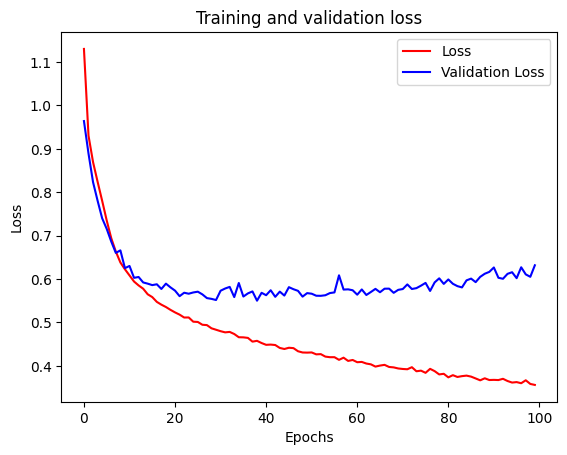

In [ ]:
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(len(history.history['loss']))]

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

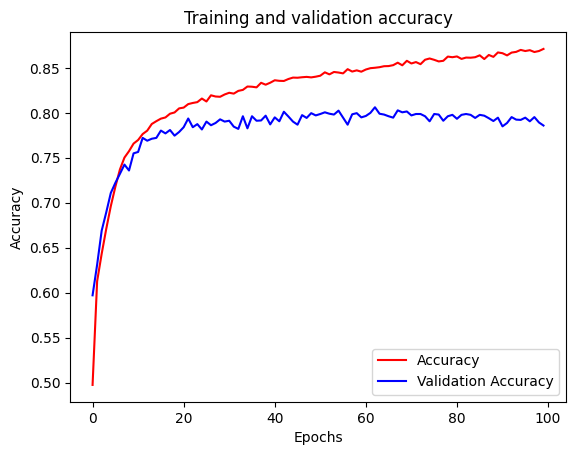

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [ ]:
y_pred = np.argmax(saved_model.predict(padded_sequences_test, verbose=0),axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(labels_test, y_pred)

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['anxiety','depression','lonely','normal'],
                     columns = ['anxiety','depression','lonely','normal'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

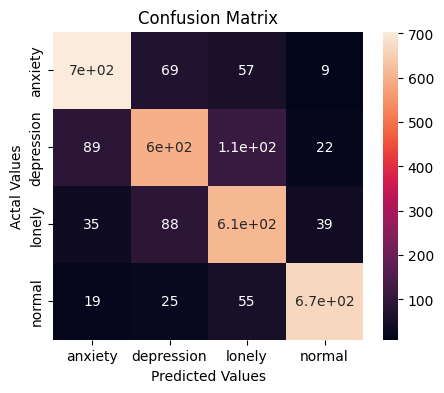

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# Save a Tokenizer

In [ ]:
# saving a tokenizer
with open('/content/drive/MyDrive/PROJECT/Model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save a Model

In [ ]:
tf.keras.models.save_model(saved_model, '/content/drive/MyDrive/PROJECT/Model/saved_model.h5')

# Using a Saved Model

In [3]:
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/PROJECT/Model/saved_model.h5')

In [ ]:
with open('/content/drive/MyDrive/PROJECT/Model/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [4]:
saved_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 25)          1061825   
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               5376      
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 132       
                                                                 
Total params: 1,068,389
Trainable params: 6,564
Non-trainable params: 1,061,825
________________________________________

In [ ]:
seed_text = str(input())
token_list = tokenizer.texts_to_sequences([seed_text])[0]
#Pad the sequences
token_list = pad_sequences([token_list],padding='post')
# Get the probabilities of predicting a word
predicted = saved_model.predict(token_list, verbose=0)[0]
print('probabilitas : ');
print('Anxiety : {:.2%}'.format(predicted[0]))
print('Depresi : {:.2%}'.format(predicted[1]))
print('Lonely : {:.2%}'.format(predicted[2]))
print('Normal : {:.2%}'.format(predicted[3]))

i feel so depressed
probabilitas : 
Anxiety : 0.95%
Depresi : 85.54%
Lonely : 9.82%
Normal : 3.69%
